## Simulation

In [1]:
from tadawol.strategies import recovery
from tadawol.strategies import record

strategy = recovery.Recovery()
data = strategy.simulate()

Historical data is extracted, rows_umber = 1083692
Simulating strategy for 2413 tickers
Simulation in progress : 8%
Simulation in progress : 17%
Simulation in progress : 25%
Simulation in progress : 33%
Simulation in progress : 41%
Simulation in progress : 50%
Simulation in progress : 58%
Simulation in progress : 66%
Simulation in progress : 75%
Simulation in progress : 83%
Simulation in progress : 91%
Simulation in progress : 99%


## Add companies general data

In [2]:
# JOIN RESULTS WITH TICKERS DATA
import pandas as pd
from math import log


from tadawol import history

tickers_data = pd.read_csv(history.TICKERS_LIST_PATH)

data = pd.merge(tickers_data, data, on="Ticker", how="inner")
data.rename(columns={"Volume_y": "Volume"}, inplace=True)


### Delete coronavirus trade periods

In [3]:
from datetime import datetime
data = data[(data["Date"] > datetime(2020, 8, 1)) | (data["Date"] < datetime(2020, 1, 1))]

## Get earnings

In [4]:
from tadawol.earnings import get_earnings_data_on_all_dates

earnings_by_date = get_earnings_data_on_all_dates(data)
print("earnings tickers number = ", earnings_by_date["Ticker"].nunique())
print("historic tickers number = ", data["Ticker"].nunique())

print("CHECK SHAPES")
print("historic data shape = ", data.shape[0])
print("earnings data shape = ", earnings_by_date.shape[0])


2020-08-31 23:53:57,327 tadawol.earnings INFO     Tickers number = 1504
2020-08-31 23:54:01,655 tadawol.earnings INFO     [Earnings] Treated tickers number = 7%
2020-08-31 23:54:05,636 tadawol.earnings INFO     [Earnings] Treated tickers number = 13%
2020-08-31 23:54:09,681 tadawol.earnings INFO     [Earnings] Treated tickers number = 20%
2020-08-31 23:54:14,020 tadawol.earnings INFO     [Earnings] Treated tickers number = 27%
2020-08-31 23:54:18,398 tadawol.earnings INFO     [Earnings] Treated tickers number = 33%
2020-08-31 23:54:22,875 tadawol.earnings INFO     [Earnings] Treated tickers number = 40%
2020-08-31 23:54:27,244 tadawol.earnings INFO     [Earnings] Treated tickers number = 47%
2020-08-31 23:54:31,474 tadawol.earnings INFO     [Earnings] Treated tickers number = 53%
2020-08-31 23:54:35,964 tadawol.earnings INFO     [Earnings] Treated tickers number = 60%
2020-08-31 23:54:40,108 tadawol.earnings INFO     [Earnings] Treated tickers number = 66%
2020-08-31 23:54:44,154 tadaw

earnings tickers number =  1491
historic tickers number =  1504
CHECK SHAPES
historic data shape =  11842
earnings data shape =  11774


In [5]:
data_with_earnings = pd.merge(data, earnings_by_date, on=["Ticker", "Date"])
print(data_with_earnings.shape[0])
print(data.shape[0])

11775
11842


## Performance code

In [6]:
from math import log

def get_volume_category(volume):
    if log(volume) <= 14:
        return "Low Volume"
    if log(volume) <= 16:
        return "Medium Volume"
    return "High Volume"

data_with_earnings["Volume_category"] = data_with_earnings.Volume.map(get_volume_category)


In [33]:
import pandas as pd
import statistics 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from prettytable import PrettyTable

def _performance_by(df, column, index):
    
    x = []
    labels = []
    occurences = []
    win_percents = []
    i = 1
    for column_value, column_data in df.groupby([column]):
        labels.append(column_value)
        x.append(i)
        occurences.append(column_data.shape[0])
        win_percents.append(column_data["win_percent"].mean())
        i += 1
    
    f = plt.figure(index)
    plt.plot(x, occurences)
    plt.plot(x, len(x)* [statistics.mean(occurences)])
    plt.xticks(x, labels, rotation='vertical')
    f.show()
    
    index += 1
    g = plt.figure(index)
    plt.plot(x, win_percents)
    plt.xticks(x, labels, rotation='vertical')
    g.show()


def get_win(df, total_amount: int, min_invest_per_trade: float, max_trades_by_day):
    
    transaction_min = min_invest_per_trade * total_amount
    transaction_max = 2 * transaction_min
    current_amount = total_amount
    df = df.sort_values(by="Date", ascending=True)
    date = df["Date"].min()
    
    returned_money_by_date = dict()
    trade_fees = 0
    realized_trades = []
    while date < datetime.now():
        
        #recuperate money
        money_to_recupere = returned_money_by_date.get(date, 0)
        current_amount += money_to_recupere
        returned_money_by_date[date] = 0
        
        # see available money
        day_trades = df[df["Date"] == date]
        day_trades_number = min(day_trades.shape[0], max_trades_by_day)
        if day_trades_number == 0 or current_amount/day_trades_number < transaction_min:
            date += timedelta(days=1)
            continue
        
        money_by_trade = current_amount/day_trades_number
        money_by_trade = min(money_by_trade, transaction_max)
        
        
        # SORT BY EARNINGS
        day_trades.sort_values(by="earnings_surprise", ascending=False, inplace=True)
        
        trade_number = 0
        for _, trade_row in day_trades.iterrows():
            trade_number += 1
            
            current_amount -= money_by_trade
            trade_fees += 2
            # add money to exit
            
            money_returned = (1 + trade_row["win_percent"]/100.0) * money_by_trade
            exit_date = trade_row["exit_date"]
            returned_money_on_exit = returned_money_by_date.get(exit_date, 0)
            returned_money_by_date[exit_date] = returned_money_on_exit + money_returned
            
            realized_trades.append(
                [
                    trade_row["Ticker"], 
                    date, 
                    trade_row["exit_date"],
                    trade_row["Close"], 
                    trade_row["exit_price"], 
                    trade_row["win_percent"]
                ]
            )
            
            if trade_number == day_trades_number:
                break
        
        date += timedelta(days=1)
        
    rest_money = 0
    for m in returned_money_by_date.values():
        rest_money += m
    
    
    win = rest_money + current_amount - total_amount
    realized_trades_df = pd.DataFrame(
        data=realized_trades, 
        columns=["Ticker", "Date", "Exit date", "Enter price", "Exit price", "win_percent"])
    return win, trade_fees, realized_trades_df

def plot_trades(trades_df, plot_index):
    
    months = []
    win_percents = []
    
    trades_df["month"] = trades_df["Date"].map(lambda x: datetime(x.year, x.month, 1))
    
    for month, month_trades in trades_df.groupby(["month"]):
        trades_product = 1
        months.append(month)
        win_percents.append( month_trades["win_percent"].mean())
        
    f = plt.figure(plot_index)
    x = range(1, len(months) + 1)
    plt.plot(x, win_percents)
    plt.xticks(x, months, rotation='vertical')
    f.show()
    
def analyse_results(df: pd.DataFrame, print_figures: bool = True, total_amount=20000, min_invest_per_trade=0.02, max_trades_by_day=2) -> None:
    assert 0 < min_invest_per_trade <= 0.1
    df = df.copy(deep=True)
    min_date = df["Date"].min()
    max_date = df["Date"].max()
    days_number = (5.0 / 7.0) * (max_date - min_date).total_seconds() / (60 * 60 * 24)
    win, trade_fees, realized_trades_df = get_win(df, total_amount, min_invest_per_trade, max_trades_by_day)
    
    
    x = PrettyTable()
    x.field_names = ["KPI", "value"]

    x.add_row(["Enter cases number", df.shape[0]])
    x.add_row(["Cases number per day", round(df.shape[0]/days_number, 2)])
    x.add_row(["Average winning cases", round(100 * df[df["win_percent"] >= 0].shape[0] / df.shape[0], 1)])
    x.add_row(["Average win", round(df["win_percent"].mean(), 2)])
    x.add_row([f"Win for {round(total_amount/1000)} K€", round(win)])
    x.add_row(["Trade fees", trade_fees])
    x.add_row(["Trade number", realized_trades_df.shape[0]])
    x.add_row(["Total margin", round(100 * (win - trade_fees)/total_amount, 1)])
    print(x)
    
    df.loc[:, "win_percent"] = df["win_percent"].astype(float)
    print(df[["win_percent"]].hist(bins=50))
    
    plot_trades(realized_trades_df, 2)
    
    if not print_figures:
        return realized_trades_df
    
        
    df.loc[:, "month"] = df['Date'].map(lambda x: f"{x.month}/{x.year}")
    
    
    index = 3
    labels = ["month", "Country", "Sector", "week_previous_entries", "Volume_category"]
    for label in labels:
        _performance_by(df, label, index)
        index += 2
        
    return realized_trades_df

def print_bad_cases(df: pd.DataFrame, cases_number: int):

    df = df.sort_values(by=["win_percent", "Date"], ascending=True)
    print(df.head(cases_number)[["Ticker", "Date", "win_percent", "company_short_name", "Country", "Sector", "days_to_next_result", "days_since_last_result","exit_date", "Close", "Open", "exit_price",]])
    

/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


+-----------------------+-------+
|          KPI          | value |
+-----------------------+-------+
|   Enter cases number  | 11775 |
|  Cases number per day | 23.06 |
| Average winning cases |  54.5 |
|      Average win      |  0.79 |
|     Win for 20 K€     |  399  |
|       Trade fees      |   50  |
|      Trade number     |   25  |
|      Total margin     |  1.7  |
+-----------------------+-------+
[[<AxesSubplot:title={'center':'win_percent'}>]]


/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


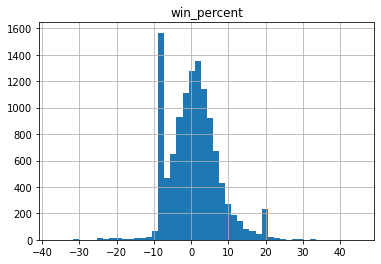

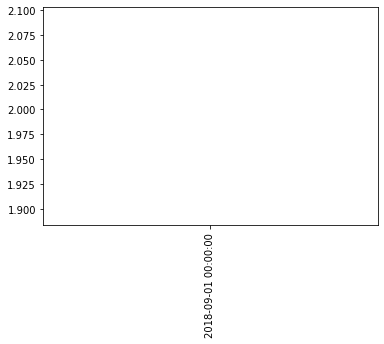

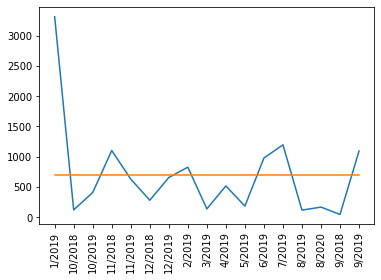

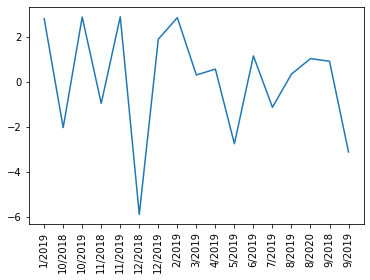

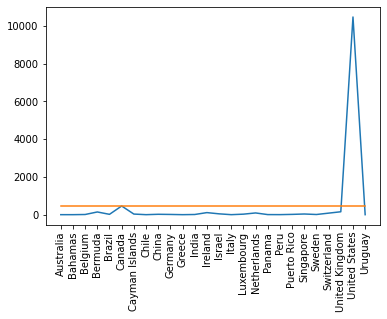

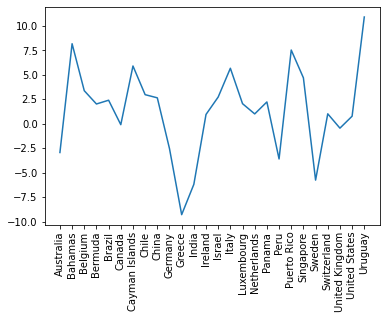

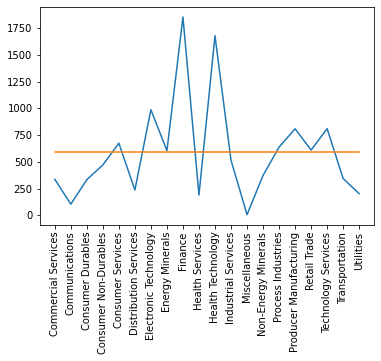

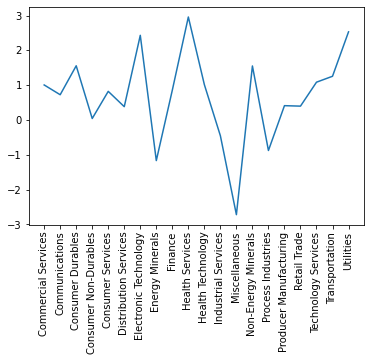

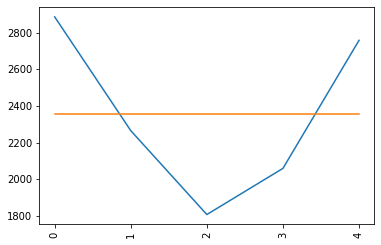

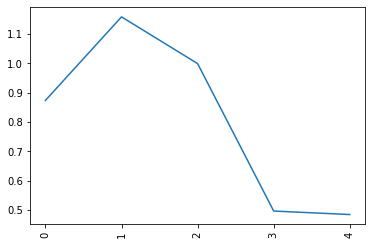

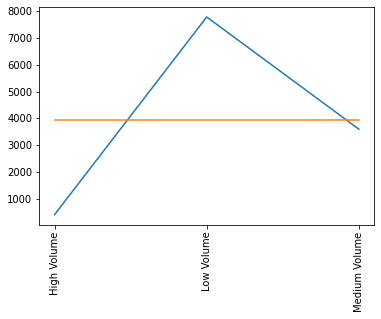

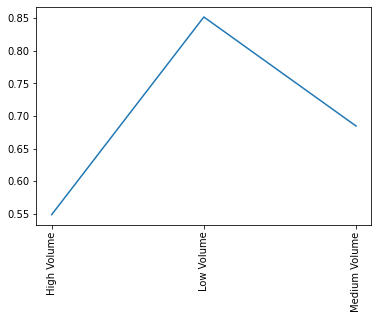

In [19]:
trades = analyse_results(data_with_earnings, print_figures=True, max_trades_by_day=3)

## Test number of entries per week

/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


+-----------------------+-------+
|          KPI          | value |
+-----------------------+-------+
|   Enter cases number  |  5539 |
|  Cases number per day | 10.85 |
| Average winning cases |  55.0 |
|      Average win      |  0.71 |
|     Win for 20 K€     |  178  |
|       Trade fees      |   52  |
|      Trade number     |   26  |
|      Total margin     |  0.6  |
+-----------------------+-------+
[[<AxesSubplot:title={'center':'win_percent'}>]]


/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


,Ticker,Date,Exit date,Enter price,Exit price,win_percent,month
0,TFX,2018-09-05,10.0,242.520004,268.940002,10.893946,2018-09-01
1,BK,2018-09-05,10.0,52.250000,51.450001,-1.531099,2018-09-01
2,EBIX,2018-09-06,10.0,78.500000,78.849998,0.445857,2018-09-01
3,TFX,2018-09-06,10.0,248.000000,270.589996,9.108869,2018-09-01
4,EBIX,2018-09-07,10.0,79.750000,79.800003,0.062700,2018-09-01
5,TFX,2018-09-07,10.0,248.149994,270.029999,8.817250,2018-09-01
6,GPRK,2018-09-10,10.0,18.450001,19.000000,2.981024,2018-09-01
7,EBIX,2018-09-10,10.0,79.449997,80.400002,1.195727,2018-09-01
8,TFX,2018-09-10,10.0,252.779999,269.750000,6.713348,2018-09-01
9,LOGM,2018-09-11,10.0,85.500000,86.750000,1.461988,2018-09-01


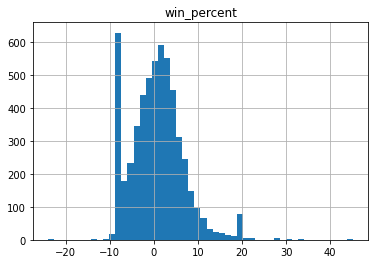

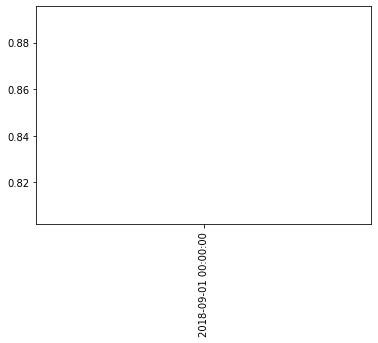

In [28]:
data_1 = data_with_earnings[data_with_earnings["days_to_next_result"] >= 15]
data_1 = data_1[data_1["days_since_last_result"] > 0]
data_1 = data_1[data_1["earnings_surprise"] > 0]
analyse_results(data_1, False, max_trades_by_day=4)

In [34]:
print_bad_cases(data_1, 20)

      Ticker       Date win_percent                 company_short_name  \
10236   ADTN 2019-09-30    -23.9648                       ADTRAN, Inc.   
10235   ADTN 2019-09-27    -23.6283                       ADTRAN, Inc.   
6593      HI 2019-07-11    -13.1721                  Hillenbrand, Inc.   
2403     BKI 2018-11-15    -10.8611                 Black Knight, Inc.   
3519     AEG 2018-11-15    -10.2941                         Aegon N.V.   
502      VMW 2019-07-31    -9.90888                       VMware, Inc.   
3212    FIVN 2018-11-14    -9.85269                        Five9, Inc.   
2402     BKI 2018-11-14     -9.8096                 Black Knight, Inc.   
7566     AEO 2019-07-30    -9.71202    American Eagle Outfitters, Inc.   
4742    NEWR 2018-12-17    -9.69108                    New Relic, Inc.   
7567     AEO 2019-07-31    -9.60995    American Eagle Outfitters, Inc.   
8612    EPAC 2018-12-03    -9.59634           Enerpac Tool Group Corp.   
7280     RRC 2019-09-25    -9.45946   

In [ ]:
print(data_1.columns)

### Add benefits dates

## Analyse by earnings

In [ ]:
def print_earnings_results(df):
    print("days_since_last_result : ", df["days_since_last_result"].mean())
    print("days_to_next_result : ", df["days_to_next_result"].mean())
    print("average earnings surprise: ", df["earnings_surprise"].mean())


cleaned_earnings = data_with_earnings[(data_with_earnings["earnings_surprise"] < 100) & (data_with_earnings["earnings_surprise"] > -100)]
print("***** GENERAL DATA ***** ")
print_earnings_results(cleaned_earnings)

print("***** POSITIVE DATA ***** ")
positive_data = cleaned_earnings[cleaned_earnings["win_percent"] > 0]
print_earnings_results(positive_data)

print("***** NEGATIVE DATA ***** ")
negative_data = cleaned_earnings[cleaned_earnings["win_percent"] < 0]
print_earnings_results(negative_data)

In [ ]:
analyse_results(data_with_earnings[(data_with_earnings["earnings_surprise"] > -20) & (data_with_earnings["week_previous_entries"] >= 2)], False)

### Top companies

In [35]:
data_with_earnings.columns

Index(['Ticker', 'Volume_x', 'Market Capitalization', 'Sector', 'Country',
       'Number of Employees', 'Industry', 'Exchange', 'Unnamed: 0', 'Date',
       'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Close_ema_40',
       'Close_ema_15', 'Close_ema_7', 'Close_ema_7_ema_10', 'slope_diff',
       'min_diff', 'entry', 'Close_1', 'Close_2', 'Close_3', 'Close_4',
       'Close_5', 'Close_6', 'Close_7', 'Close_8', 'Close_9', 'Close_10',
       'Open_1', 'Open_2', 'Open_3', 'Open_4', 'Open_5', 'Open_6', 'Open_7',
       'Open_8', 'Open_9', 'Open_10', 'exit_data', 'exit_price', 'exit_date',
       'win_percent', 'Date_1', 'Date_2', 'Date_3', 'Date_4',
       'week_previous_entries', 'company_short_name', 'earnings_date',
       'next_earnings_date', 'earnings_estimate', 'real_earnings',
       'earnings_surprise', 'days_since_last_result', 'days_to_next_result',
       'Volume_category'],
      dtype='object')

/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

+-----------------------+-------+
|          KPI          | value |
+-----------------------+-------+
|   Enter cases number  |  1023 |
|  Cases number per day |  2.01 |
| Average winning cases |  61.3 |
|      Average win      |  0.88 |
|     Win for 20 K€     |  154  |
|       Trade fees      |   50  |
|      Trade number     |   25  |
|      Total margin     |  0.5  |
+-----------------------+-------+
[[<AxesSubplot:title={'center':'win_percent'}>]]


/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


,Ticker,Date,Exit date,Enter price,Exit price,win_percent,month
0,BK,2018-09-05,10.0,52.250000,51.450001,-1.531099,2018-09-01
1,PM,2018-09-28,10.0,81.540001,82.309998,0.944318,2018-09-01
2,PM,2018-10-01,10.0,81.820000,82.309998,0.598873,2018-10-01
3,SCCO,2018-10-03,10.0,43.750000,41.900002,-4.228567,2018-10-01
4,SCCO,2018-10-04,10.0,42.660000,41.860001,-1.875291,2018-10-01
5,SRE,2018-10-18,8.0,115.910004,111.800003,-3.545855,2018-10-01
6,SRE,2018-10-19,7.0,116.610001,111.800003,-4.124859,2018-10-01
7,SO,2018-10-22,9.0,44.970001,44.740002,-0.511450,2018-10-01
8,SRE,2018-10-22,6.0,115.620003,111.800003,-3.303927,2018-10-01
9,SO,2018-10-23,8.0,44.730000,44.740002,0.022361,2018-10-01


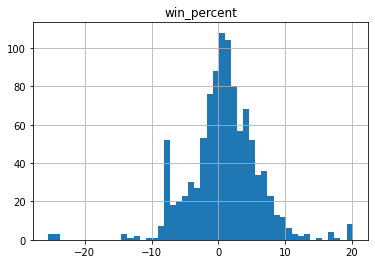

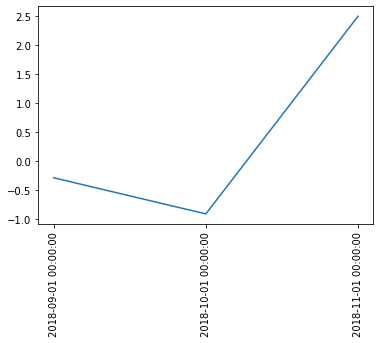

In [43]:
tickers_df = data_with_earnings[["Ticker", "Market Capitalization"]]
tickers_df.drop_duplicates(inplace=True)
tickers_df.sort_values(by="Market Capitalization", ascending=False, inplace=True)
tickers_df.reset_index(drop=True, inplace=True)

top_tickers = tickers_df.head(150)

top_companies_entries = pd.merge(data_with_earnings, top_tickers, on=["Ticker", "Market Capitalization"])
analyse_results(top_companies_entries, False)
